Quick Notes:
* Is this the same as the chisquare test I was using - https://www.itl.nist.gov/div898/handbook/prc/section4/prc46.htm
* Traditional test for which ranked items are significantly greater - https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm
* Beta-Binomial Tutorial - http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/
* Multilevel Beta-Binomial - https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/
* Another Beta Binomial Tutorial - https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
* Pymc3 Beta Binomial Tutorial - https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html
* Another pymc3 beta binomial - https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/
* Note how the beta priors are created (the 5/2 thing). Test this in other regression with pymc3 project.
* Multi-level beta binomial question - https://stats.stackexchange.com/questions/230034/extending-a-hierarchical-beta-binomial-model-to-account-for-higher-level-groups
* Multilevel pymc3 - https://austinrochford.com/posts/2017-07-09-mrpymc3.html
* Partial Pooling - https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html

In [1]:
%%bash
head ../processed_data/all_walks_pa.out

aaroh101, Hank Aaron, 74, 598, 1970
aarot101, Tommie Aaron, 3, 66, 1970
abert101, Ted Abernathy, 0, 20, 1970
adaij101, Jerry Adair, 5, 33, 1970
ageet101, Tommie Agee, 55, 696, 1970
aguih101, Hank Aguirre, 0, 2, 1970
akerj102, Jack Aker, 0, 16, 1970
alcal101, Luis Alcaraz, 4, 127, 1970
alleb105, Bernie Allen, 43, 305, 1970
alled101, Dick Allen, 71, 533, 1970


In [2]:
import pandas as pd

DF = pd.read_csv('../processed_data/all_walks_pa.out',
                 header=None,
                 names=['playerid', 'player_name', 'walks', 'pa', 'year'])

In [3]:
DF.head()

,playerid,player_name,walks,pa,year
0,aaroh101,Hank Aaron,74,598,1970
1,aarot101,Tommie Aaron,3,66,1970
2,abert101,Ted Abernathy,0,20,1970
3,adaij101,Jerry Adair,5,33,1970
4,ageet101,Tommie Agee,55,696,1970


In [4]:
import numpy as np

GROUPED_DF = (DF
              .groupby("year")
              .agg({'walks': np.sum,
                    'pa': np.sum,
                   })
             )

GROUPED_DF["prop_walk"] = GROUPED_DF["walks"] / GROUPED_DF["pa"]

In [5]:
GROUPED_DF.describe()

,walks,pa,prop_walk
count,49.000000,49.000000,49.000000
mean,14434.530612,168774.551020,0.085571
std,1707.544986,19009.189224,0.003909
min,8868.000000,105892.000000,0.076225
25%,13518.000000,160033.000000,0.083789
50%,14227.000000,161922.000000,0.085222
75%,15806.000000,185553.000000,0.087354
max,18237.000000,190261.000000,0.095853


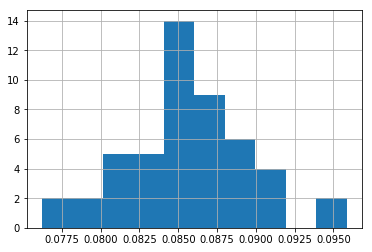

In [6]:
%matplotlib inline
GROUPED_DF["prop_walk"].hist();

In [7]:
len(GROUPED_DF)

49

In [8]:
GROUPED_DF.head()

,walks,pa,prop_walk
year,,,
1970,13727,149332,0.091923
1971,12484,145958,0.085531
1972,11715,139815,0.083789
1973,13094,148637,0.088094
1974,12963,148855,0.087085


In [9]:
GROUPED_DF

,walks,pa,prop_walk
year,,,
1970,13727,149332,0.091923
1971,12484,145958,0.085531
1972,11715,139815,0.083789
1973,13094,148637,0.088094
1974,12963,148855,0.087085
1975,13402,148621,0.090176
1976,12390,147598,0.083944
1977,13757,161547,0.085158
1978,13566,159192,0.085218


In [10]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [11]:
GROUPED_DF.shape

(49, 3)

In [12]:
with pm.Model() as bb_model:
 
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)

    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    rates = pm.Beta('rates', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(GROUPED_DF))

 
    trials = np.array(GROUPED_DF["pa"])
    successes = np.array(GROUPED_DF["walks"])
 
    obs = pm.Binomial('observed_values', trials, rates,
                      observed=successes)
    trace = pm.sample(2000, tune=1000, chains=2, cores=2, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rates, kappa_log, phi]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:38<00:00, 187.94draws/s]


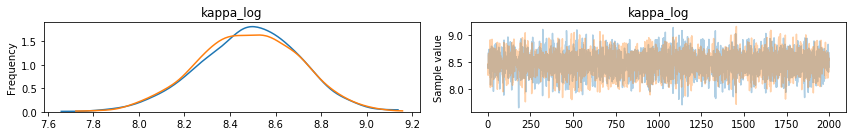

In [13]:
pm.traceplot(trace, varnames=['kappa_log']);

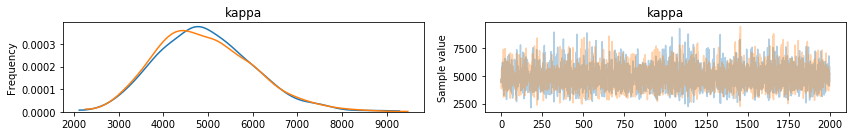

In [14]:
pm.traceplot(trace, varnames=['kappa']);

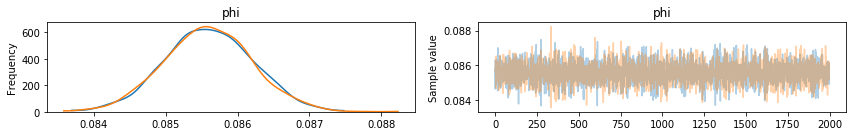

In [15]:
pm.traceplot(trace, varnames=['phi']);

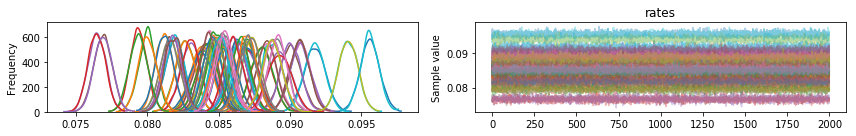

In [16]:
pm.traceplot(trace, varnames=['rates']);

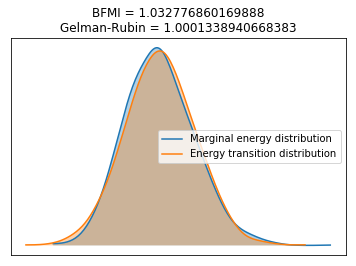

In [17]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())
(pm.energyplot(trace, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

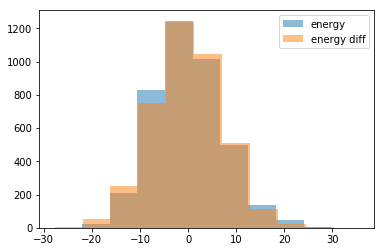

In [18]:
energy = trace['energy']
energy_diff = np.diff(energy)
plt.hist(energy - energy.mean(), label='energy', alpha=0.5)
plt.hist(energy_diff, label='energy diff', alpha=0.5)
plt.legend();

In [19]:
GROUPED_DF.head()

,walks,pa,prop_walk
year,,,
1970,13727,149332,0.091923
1971,12484,145958,0.085531
1972,11715,139815,0.083789
1973,13094,148637,0.088094
1974,12963,148855,0.087085


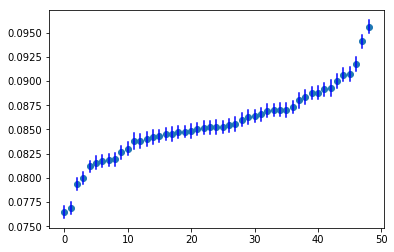

In [20]:
rate_means = trace['rates', 1000:].mean(axis=0)
rate_se = trace['rates', 1000:].std(axis=0)

mean_se = [(x, y, i) for i, x, y in zip(GROUPED_DF.index, rate_means, rate_se)]
sorted_means_se = sorted(mean_se, key=lambda x: x[0])
sorted_means = [x[0] for x in sorted_means_se]
sorted_se = [x[1] for x in sorted_means_se]

x = np.arange(len(sorted_means))

plt.plot(x, sorted_means, 'o');

for x_val, m, se in zip(x, sorted_means, sorted_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-')

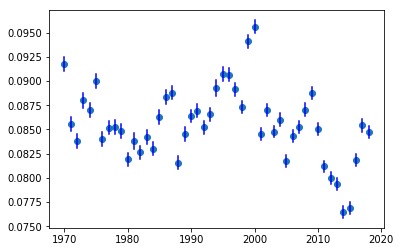

In [21]:
plt.plot(GROUPED_DF.index, rate_means, 'o');
for x_val, m, se in zip(GROUPED_DF.index, rate_means, rate_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-')

In [22]:
sorted_means_se[:5]

[(0.07646209726671635, 0.0005918003330566895, 2014),
 (0.07688963877749279, 0.0006224337494514535, 2015),
 (0.07937218775493034, 0.0006088604882029617, 2013),
 (0.08001400543286034, 0.0006207386019788478, 2012),
 (0.0811766723382111, 0.0006115530774205621, 2011)]

In [23]:
sorted_means_se[-5:]

[(0.09066824445979997, 0.0006691094857225917, 1996),
 (0.09071123822616874, 0.0007035829860009472, 1995),
 (0.0917172719443447, 0.0007240624312056991, 1970),
 (0.09409286147240523, 0.0006469790042051997, 1999),
 (0.0955956759518374, 0.0006744226015336069, 2000)]

In [24]:
GROUPED_DF.loc[[x[2] for x in sorted_means_se[-5:]], :]

,walks,pa,prop_walk
year,,,
1996,16093,177261,0.090787
1995,14240,156703,0.090873
1970,13727,149332,0.091923
1999,17891,189692,0.094316
2000,18237,190261,0.095853


In [25]:
GROUPED_DF.loc[[x[2] for x in sorted_means_se[:5]], :]

,walks,pa,prop_walk
year,,,
2014,14020,183929,0.076225
2015,14073,183627,0.076639
2013,14640,184873,0.079189
2012,14709,184179,0.079863
2011,15018,185245,0.081071


GridSpec(1, 2, width_ratios=[3, 1])

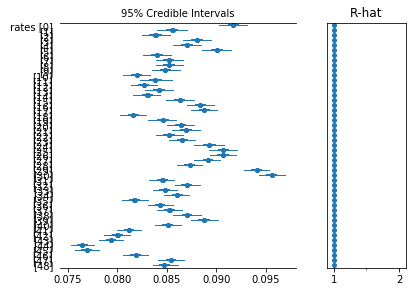

In [26]:
pm.plots.forestplot(trace, varnames=["rates"])